In [8]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=9, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*3*3, 8)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.adaptive_max_pool2d(x, (3, 3))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [10]:
# Load the saved model
def load_model(model_path, device):
    model = CNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Define the dataset and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
])
def load_data(data_path, batch_size=32):
    dataset = ImageFolder(data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

In [11]:
# Evaluate the model
def evaluate_model(model, dataloader, device):
    # Initialize the lists to store the true labels and predictions
    all_labels = []
    all_preds = []
    with torch.no_grad():
        # Iterate over the dataloader
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Forward pass
            _, preds = torch.max(outputs, 1) # Get the predicted class
            all_labels.extend(labels.cpu().numpy()) # Store the true labels
            all_preds.extend(preds.cpu().numpy()) # Store the predictions
    
    # Convert the lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    # Calculate all the stats
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_micro = precision_score(all_labels, all_preds, average='micro')
    recall_micro = recall_score(all_labels, all_preds, average='micro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    
    return cm, accuracy, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro


In [12]:
# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.tight_layout()
    plt.show()

# Plot results table
def plot_results_table(df_results):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title('Model Evaluation Results')
    plt.show()

In [13]:
def main(model_paths, data_path):
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    dataloader = load_data(data_path)
    class_names = dataloader.dataset.classes

    for model_name, model_path in model_paths.items():
        model = load_model(model_path, device)
        cm, accuracy, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro = evaluate_model(model, dataloader, device)
        
        print(f'\nModel: {model_name}')
        print('Confusion Matrix:')
        print(cm)
        print(f'Accuracy: {accuracy:.5f}')
        print(f'Macro Precision: {precision_macro:.5f}')
        print(f'Macro Recall: {recall_macro:.5f}')
        print(f'Macro F1: {f1_macro:.5f}')
        print(f'Micro Precision: {precision_micro:.5f}')
        print(f'Micro Recall: {recall_micro:.5f}')
        print(f'Micro F1: {f1_micro:.5f}')
        
        plot_confusion_matrix(cm, class_names, model_name)


Model: Best Model
Confusion Matrix:
[[462  36  39  44   4  41  58  39]
 [ 44 404  17  10  23  50  31  43]
 [133  40 256  61  26  21  83  56]
 [ 28   4  10 408   5   8  29 108]
 [ 11  75  23   9 685  10  14  43]
 [ 51  71   9  37   7 269  73  99]
 [ 80  28  31  63   5  43 333  39]
 [ 32  17  10 178  14  44  37 563]]
Accuracy: 0.60100
Macro Precision: 0.60234
Macro Recall: 0.59196
Macro F1: 0.58904
Micro Precision: 0.60100
Micro Recall: 0.60100
Micro F1: 0.60100


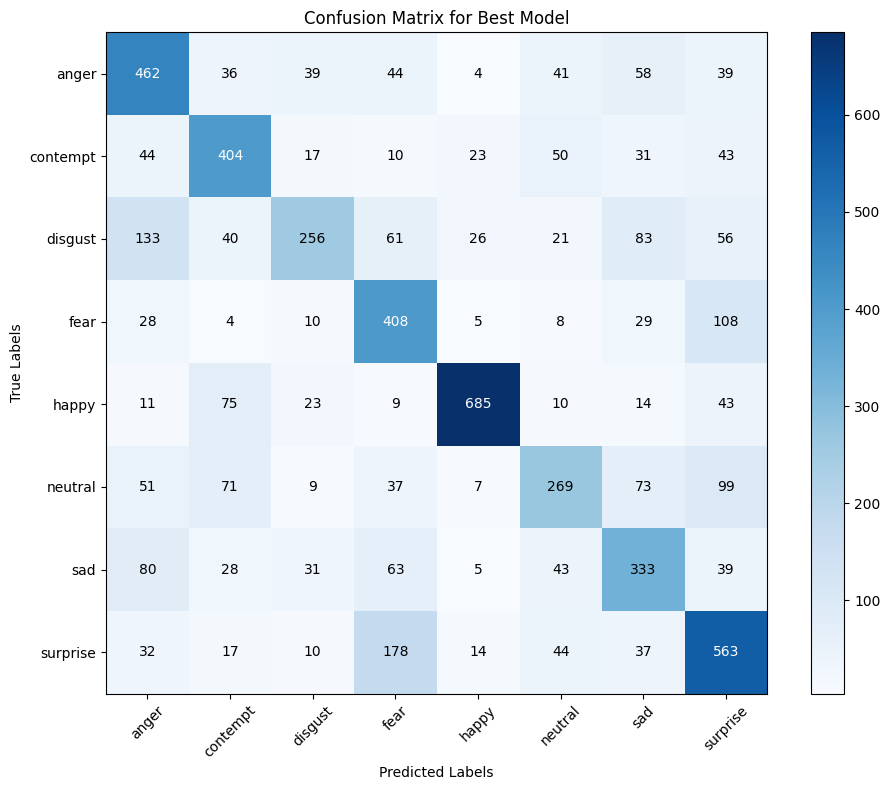

In [14]:
if __name__ == "__main__":
    model_paths = {
        'Best Model': './models/model_6713.pth',
    }
    data_path = './database/test'
    main(model_paths, data_path)